{1: {'model': <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x17e8fe570>, 'aic': 307.9819719428387, 'bic': 310.4197235925751, 'r2': 0.3177889489354756, 'pvalue': 0.0033385241540964815}, 2: {'model': <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x1579add30>, 'aic': 304.00715014206725, 'bic': 307.66377761667184, 'r2': 0.46281303643422633, 'pvalue': 0.00107492982131053}}
{1: {'model': <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x17f2e25a0>, 'aic': 332.9428001480246, 'bic': 335.38055179776103, 'r2': 0.10059394097807905, 'pvalue': 0.1223857109224635}, 2: {'model': <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x17f2e18b0>, 'aic': 310.02949630588864, 'bic': 313.68612378049323, 'r2': 0.6679775930785952, 'pvalue': 5.405567928309791e-06}}
{1: {'model': <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x17f2e10d0>, 'aic': 311.3165531328485, 'bic': 313.75430478258494,

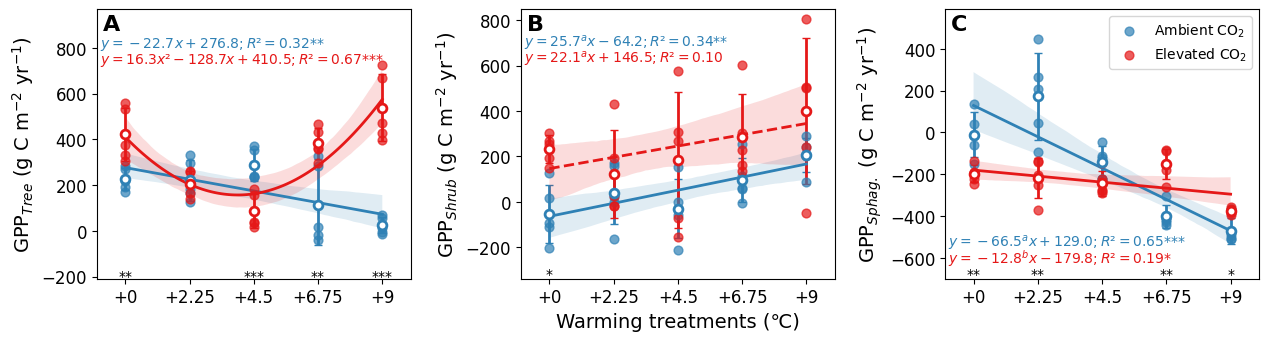

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.gridspec as gridspec
from scipy.stats import linregress
from scipy.stats import ttest_1samp
from scipy.stats import ttest_rel
import numpy as np
import statsmodels.formula.api as smf

def cal_reg_diff(x_ambient, y_ambient, x_elevated, y_elevated):
    """
    Fits y ~ x + group + x:C(group) and returns the p‑values for
    differences in slope and intercept between the two groups.  If only
    one group is present the p‑values will be None.
    """
    # Create a DataFrame with a categorical group column
    x = np.concatenate([x_ambient, x_elevated])
    y = np.concatenate([y_ambient, y_elevated])
    group_labels = (['ambient'] * len(x_ambient)) + (['elevated'] * len(x_elevated))
    df = pd.DataFrame({'y': y, 'x': x, 'group': group_labels})
    df['group'] = df['group'].astype('category')

    # Fit the model
    model = smf.ols('y ~ x + group + x:C(group)', data=df).fit()

    # Dynamically extract p‑values for group effects
    slope_pval = None
    intercept_pval = None
    for term, pval in model.pvalues.items():
        if term.startswith('x:C(group)'):
            slope_pval = pval
        elif term.startswith('C(group)'):
            intercept_pval = pval

    # slope_pval and intercept_pval will be None if there is only one group
    if slope_pval is not None and slope_pval < 0.05:
        res_ab_slope = ('a', 'b')
    else:
        res_ab_slope = ('a', 'a')

    if intercept_pval is not None and intercept_pval < 0.05:
        res_ab_intercept = ('a', 'b')
    else:
        res_ab_intercept = ('a', 'a')

    return res_ab_slope, res_ab_intercept

import statsmodels.api as sm
import statsmodels.formula.api as smf

def fit_model(x, y, max_order=2):
    """Fit linear and quadratic models and select the best one based on AIC."""
    results = {}
    
    for order in [1, 2]:
        if order == 1:
            X = sm.add_constant(x)
        else:
            X = sm.add_constant(np.column_stack((x, x**2)))
            
        model = sm.OLS(y, X).fit()
        results[order] = {
            'model': model,
            'aic': model.aic,
            'bic': model.bic,
            'r2': model.rsquared,
            'pvalue': model.f_pvalue
        }
    
    # Select best model (difference in AIC > 5 means significantly better)
    if abs(results[1]['aic'] - results[2]['aic']) > 5:
        best_order = 2 if results[2]['aic'] < results[1]['aic'] else 1
    else:
        best_order = 1  # Default to simpler model if difference is small
    
    print(results)
    
    return results[best_order], best_order

def format_equation(params, order, r2, pvalue, ab_slope, ab_inter):
    """Format the regression equation as a string."""
    if order == 1:
        b, a = params
        sign_b = '-' if b < 0 else '+'
        equation = f"$y = {a:.1f}^{ab_slope}x {sign_b} {abs(b):.1f}; R² = {r2:.2f}$"
    else:
        c, b, a = params
        sign_b = '-' if b < 0 else '+'
        sign_c = '-' if c < 0 else '+'
        equation = f"$y = {a:.1f}x² {sign_b} {abs(b):.1f}x {sign_c} {abs(c):.1f}; R² = {r2:.2f}$"
    
    # Add significance stars
    if pvalue < 0.001:
        equation += "***"
    elif pvalue < 0.01:
        equation += "**"
    elif pvalue < 0.05:
        equation += "*"
    
    return equation


# figure3: NPP shrub
ls_vars = ["npp_Shrub", "npp_Sphagnum", "npp_Tree", "gpp_Shrub", "gpp_Sphagnum", "gpp_Tree",  "ra_Shrub","ra_Sphagnum",  "ra_Tree"]

ls_plots = [("P06", "P19"), ("P20", "P11"), ("P13", "P04"), ("P08", "P16"), ("P17", "P10")]
ls_warmings = [0, 2.25, 4.5, 6.75, 9]

ls_dist = [-0.14, 0.14]

ls_colors = ["#2F81B5", "#E51818"]

ls_subtitles = [
    ["A", "B", "C"],
    # ["(d) Shrub", "(e) Sphagnum", "(f) Tree"],
    # ["(g) Shrub", "(h) Sphagnum", "(i) Tree"]
                ]

df_data = pd.read_excel("1_data_minus_2013.xlsx") 
df_data = df_data[df_data["year"]>2016]
df_data = df_data[["year", "plot", "warming", "co2"]+ls_vars].reset_index(drop=True)
df_data[["ra_Shrub","ra_Sphagnum",  "ra_Tree"]] = df_data[["ra_Shrub","ra_Sphagnum",  "ra_Tree"]]

fig, axes = plt.subplots(1, 3, figsize=(15,3.5))#, sharey="row", sharex=True)

ls_pox  = [[(0.01, 0.86), (0.01, 0.86), (0.01, 0.12)],
           [(0.01, 0.15), (0.01, 0.8),(0.01, 0.15)],
           [(0.01, 0.8), (0.01, 0.8),(0.01, 0.15)]]

ls_ylim = [(-209, 969), (-339, 849), (-699, 589)]
ls_pox_mark = [ -199, -319, -679]

ls_labels = ["Ambient CO$_2$", "Elevated CO$_2$"]
for idx_sps, isps in enumerate(["Tree", "Shrub", "Sphagnum"]):
    for idx_var, ivar in enumerate(["gpp"]):#, "npp", "ra"]):
        ax = axes[idx_sps]  
        ax.text(0.02,0.98,ls_subtitles[idx_var][idx_sps], va="top", ha="left", transform=ax.transAxes, fontsize=16, fontweight="bold")
        ls_x_aco2, ls_y_aco2, ls_x_eco2, ls_y_eco2 = [], [], [], []
        ls_slope = []
        ls_inter = []
        ls_R2    = []
        ls_markp = []
        ls_model = []
        ls_order = []
        for idx_co2, ico2 in enumerate([0, 500]):
            df_data_co2 = df_data[df_data["co2"]==ico2].copy()
            x = df_data_co2["warming"].values
            y = df_data_co2[ivar+"_"+isps].values
            df_data4mean = df_data_co2[["warming", ivar+"_"+isps]].copy()
            df_data_mean = df_data4mean.groupby("warming").agg(["mean", "std"]).reset_index()
            df_data_mean.columns = ["warming", "mean", "std"]
            # ------------------------------------------------
            slope, intercept, r, p, stderr = linregress(x, y)
            line_style = "-" if p < 0.05 else "--"
            mark_p = ""
            if p < 0.001:
                mark_p = "***"
            elif p<0.01:
                mark_p = "**"
            elif p <0.05:
                mark_p = "*"
            # ------------------------------------------------
            ax.errorbar(df_data_mean["warming"], df_data_mean["mean"], yerr=df_data_mean["std"], fmt='none', color=ls_colors[idx_co2], capsize=3, linewidth=2, zorder=1)
            ax.scatter(df_data_mean["warming"], df_data_mean["mean"], marker='o', s=40, 
                        color='white', edgecolor=ls_colors[idx_co2], linewidth=2, zorder=3)
            
            # Fit model
            model, order = fit_model(x, y)
            line_style = '-' if model['pvalue'] < 0.05 else '--'

            ls_order.append(order)
            ls_model.append(model)

            sns.regplot(x=x, y=y, ax=ax, order=order, scatter_kws={"zorder": 2, "s": 40, "alpha": 0.7, "color": ls_colors[idx_co2]},
                line_kws={"zorder": 2, "color": ls_colors[idx_co2], "lw": 2, "linestyle": line_style}, label=ls_labels[idx_co2])
            
            # ax.text(ls_pox[idx_sps][0], ls_pox[idx_sps][1]-0.07*idx_co2,
            #         f"y = {slope:.1f}x+{intercept:.1f}; R$^2$ = {r*r:.2f}"+(rf"$^{{{mark_p}}}$" if mark_p else ""),
            #         transform=ax.transAxes, fontsize=10, color=ls_colors[idx_co2])
            # -------------------------------------------------
            ls_slope.append(slope)
            ls_inter.append(intercept)
            ls_R2.append(r*r)
            ls_markp.append(mark_p)
            if ico2 == 0: 
                ls_x_aco2.extend(x)
                ls_y_aco2.extend(y)
            else:
                ls_x_eco2.extend(x)
                ls_y_eco2.extend(y)
        inter_slope, _ = cal_reg_diff(ls_x_aco2, ls_y_aco2, ls_x_eco2, ls_y_eco2)

        mark_order = 0
        for idx_co2 in range(2):
            if ls_order[idx_co2] ==2: mark_order = 1 

        if mark_order == 0:
            res_ab_slope, res_ab_intercept = cal_reg_diff(ls_x_aco2, ls_y_aco2, ls_x_eco2, ls_y_eco2)
        else:
            res_ab_slope, res_ab_intercept = ('\u200B', '\u200B'), ('\u200B', '\u200B')

        for idx_co2, ico2 in enumerate([0,500]):
            
            ab_slope = res_ab_slope[0]     if idx_co2 == 0 else res_ab_slope[1]
            ab_inter = res_ab_intercept[0] if idx_co2 == 0 else res_ab_intercept[1]
            order    = ls_order[idx_co2]
            model    = ls_model[idx_co2]
            equation = format_equation(model['model'].params, order, model['r2'], model['pvalue'], ab_slope, ab_inter)
            # y_pos = i_pos[1] if treatment == 'Ambient' else i_pos[2]
            ax.text(ls_pox[idx_var][idx_sps][0], ls_pox[idx_var][idx_sps][1]-0.06*idx_co2,
                    equation,
                    transform=ax.transAxes, fontsize=10, color=ls_colors[idx_co2])
        # -----------------
        for idx_warming, iwarm in enumerate([0, 2.25, 4.5, 6.75, 9]):
            y_aco2 = df_data[(df_data["warming"]==iwarm)&(df_data["co2"]==0)][ivar+"_"+isps].values
            y_eco2 = df_data[(df_data["warming"]==iwarm)&(df_data["co2"]==500)][ivar+"_"+isps].values
            _, p_value = ttest_rel(y_aco2, y_eco2)
            if p_value < 0.05:
                marker = '*' if p_value < 0.05 else ''
                marker = '**' if p_value < 0.01 else marker
                marker = '***' if p_value < 0.001 else marker
                ax.text(iwarm, ls_pox_mark[idx_sps], 
                        marker, ha='center', va='center', fontsize=10)
        # ---------------------------
        ax.tick_params(axis='x', labelsize=12)
        ax.tick_params(axis='y', labelsize=12)
        ax.set_xlim(-1,10)

# ------------------------------------------------------------------------------------------------------
ls_ylabels = [r'GPP'+'$_{Tree}$ (g C m$^{-2}$ yr$^{-1}$)',
    r'GPP'+'$_{Shrub}$ (g C m$^{-2}$ yr$^{-1}$)', 
              r'GPP'+'$_{Sphag.}$ (g C m$^{-2}$ yr$^{-1}$)', 
              ]
custom_x_ticks  = [0,      2.25,    4.5,    6.75,    9]  # x stick
custom_x_labels = ['+0', '+2.25', '+4.5', '+6.75', '+9']


for i in range(3):
    axes[i].set_ylabel(ls_ylabels[i], fontsize=14)
    axes[i].set_xticks(custom_x_ticks)
    axes[i].set_xticklabels(custom_x_labels)
    axes[i].set_ylim(ls_ylim[i])

axes[1].set_xlabel('Warming treatments (℃)', fontsize=14)
# ax4.legend(fontsize=10)
# ls_axes = [ax0, ax1, ax2, ax3, ax4]

# ls_subtitles = ["(a)", "(b)", "(c) Shrub", "(d) Sphagnum", "(e) Tree"]
# for idx_ax, ax in enumerate(ls_axes):
#     ax.text(0.01, 0.98, ls_subtitles[idx_ax], va="top", ha="left", transform=ax.transAxes, fontsize=16)
#     ax.tick_params(axis='x', labelsize=12)
#     ax.tick_params(axis='y', labelsize=12)
#     if not idx_ax == 1:
#         ax.set_xlim(-1, 10)
#         ax.set_xticks(custom_x_ticks)
#         ax.set_xticklabels(custom_x_labels)
#         ax.set_xlabel('Warming treatments (℃)', fontsize=14)
# ax0.set_ylabel("CO$_2$ effect on NCE\n(g C m$^{-2}$ yr$^{-1}$)", fontsize=14)
# ax1.set_xlabel("CO$_2$ effect on flux components (g C m$^{-2}$ yr$^{-1}$)", fontsize=14)
# ax1.set_ylabel("CO$_2$ effect on NCE\n(g C m$^{-2}$ yr$^{-1}$)", fontsize=14)
# ax2.set_ylabel("NPP components\n(g C m$^{-2}$ yr$^{-1}$)", fontsize=14)

axes[2].legend()
# axes[2, 0].set_ylim(-400, 899)

fig.align_ylabels()
plt.subplots_adjust(wspace=0.35, hspace=0)